In [57]:
import glob
import json
import os
from PIL import Image, ImageDraw
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CarDamageDataset(Dataset):
    def __init__(self, json_dir, img_dir, transform=None):
        self.json_files = glob.glob(os.path.join(json_dir, "*.json"))
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.json_files)

    def __getitem__(self, idx):
        # JSON 파일을 로드합니다.
        json_path = self.json_files[idx]
        with open(json_path, 'r') as j:
            annotation = json.load(j)
        
        img_file_name = os.path.splitext(os.path.basename(json_path))[0] + '.jpg'
        img_path = os.path.join(self.img_dir, img_file_name)
        
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Image file not found for: {img_path}")
            raise
        
        mask = Image.new("L", (image.width, image.height), 0)
        draw = ImageDraw.Draw(mask)
        for seg in annotation['annotations'][0]['segmentation']:
            # seg 예상 구조: [[[x1, y1], [x2, y2], ..., [xn, yn]]]
            polygon = [(point[0], point[1]) for point in seg[0]]
            draw.polygon(polygon, outline=1, fill=1)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            if mask.size(0) > 1:
                mask = mask[0].unsqueeze(0)
        
        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = CarDamageDataset(json_dir='../../car_data/all/json',
                           img_dir='../../car_data/all/img',
                           transform=transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
import torch
from torch import nn, optim
import segmentation_models_pytorch as smp


class Unet(nn.Module):
    def __init__(self, num_classes,encoder,pre_weight):
        super().__init__()
        self.model = smp.Unet( classes = num_classes,
                              encoder_name=encoder,
                              encoder_weights=pre_weight,
                              in_channels=3)
    
    def forward(self, x):
        y = self.model(x)
        return y

In [ ]:
# Define device: Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
num_classes = 1  # Adjust based on your dataset's requirements
model = Unet(num_classes=num_classes, encoder='resnet34', pre_weight='imagenet').to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary classification, adjust if necessary
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training settings
num_epochs = 100  # Adjust according to your needs



In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for images, masks in data_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(data_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

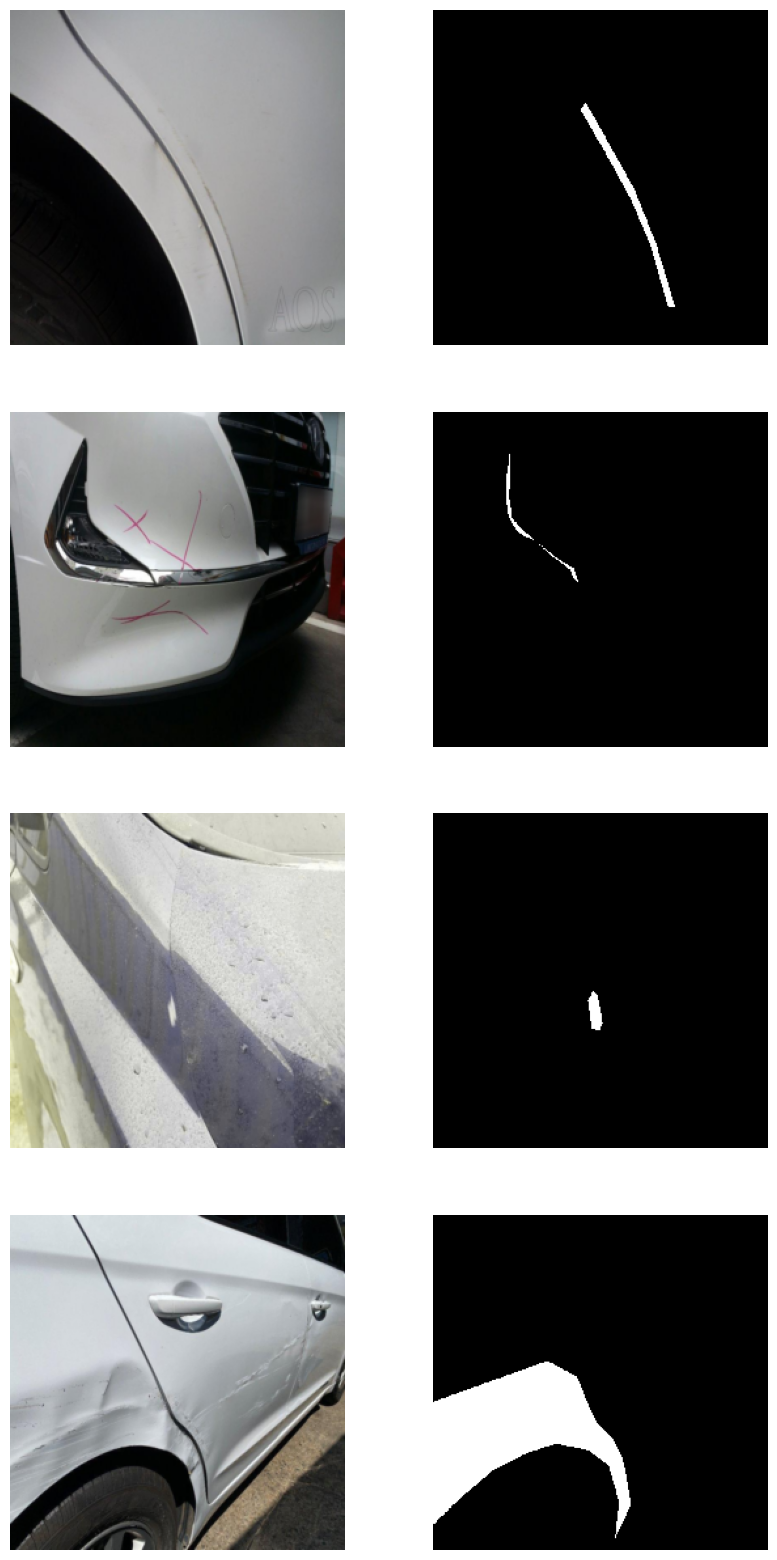

In [58]:
# import matplotlib.pyplot as plt

# def visualize_data(loader, num_images=4):
#     fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    
#     for i_batch, sample_batched in enumerate(loader):
#         images, masks = sample_batched
#         images = images.numpy()  # 이미지 텐서를 numpy 배열로 변환
#         masks = masks.numpy()  # 마스크 텐서를 numpy 배열로 변환
        
#         for i in range(num_images):
#             # 첫 번째 열에 이미지 시각화
#             axs[i, 0].imshow(np.transpose(images[i], (1, 2, 0)))  # PyTorch: C x H x W -> H x W x C
#             axs[i, 0].axis('off')
            
#             # 두 번째 열에 마스크 시각화
#             axs[i, 1].imshow(masks[i].squeeze(), cmap='gray')  # 마스크의 경우 채널이 1이므로 squeeze 사용
#             axs[i, 1].axis('off')
        
#         # 한 배치에서 지정된 수의 이미지만 시각화
#         if i >= num_images - 1:
#             break
            
#     plt.show()

# # 데이터 로더에서 이미지와 GT를 시각화
# visualize_data(data_loader)